## Tensorflow Hub pre-trained models for segmentation

In [6]:
! pip install tensorflow_hub

  Obtaining dependency information for tensorflow_hub from https://files.pythonhosted.org/packages/30/78/9d5292a2b616901bdb075bbf0c777b293f4140bb48108ac2b33fd716c2eb/tensorflow_hub-0.14.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/90.3 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/90.3 kB ? eta -:--:--
   ------------- -------------------------- 30.7/90.3 kB 435.7 kB/s eta 0:00:01
   ------------------ --------------------- 41.0/90.3 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 90.3/90.3 kB 567.5 kB/s eta 0:00:00


In [7]:
import os
import numpy as np
import cv2
import zipfile
import requests
import glob as glob

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import warnings 
import logging
import absl

# filter absl warnings
warnings.filterwarnings("ignore", module="absl")

# capture all warnings in the true logging system
logging.captureWarnings(True)

# set all the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


## 1 Download sample (CamVid) images

In [8]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [10]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [12]:
download_file('https://www.dropbox.com/s/5jhbvmqgzbzl9fd/camvid_images.zip?dl=1',
              'camvid_images.zip')

unzip(zip_file='camvid_images.zip')

Extracted all


### Display sample images

In [14]:
image_paths = sorted(glob.glob('camvid_images' + '/*.png'))

for idx in range(len(image_paths)):
    print(image_paths[idx])

camvid_images\camvid_sample_1.png
camvid_images\camvid_sample_2.png
camvid_images\camvid_sample_3.png
camvid_images\camvid_sample_4.png


In [15]:
def load_image(path):

    image = cv2.imread(path)

    #convert image in BGR fromat to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add batch dimension required by the model
    image = np.expand_dims(image, axis = 0)/255.0

    return image

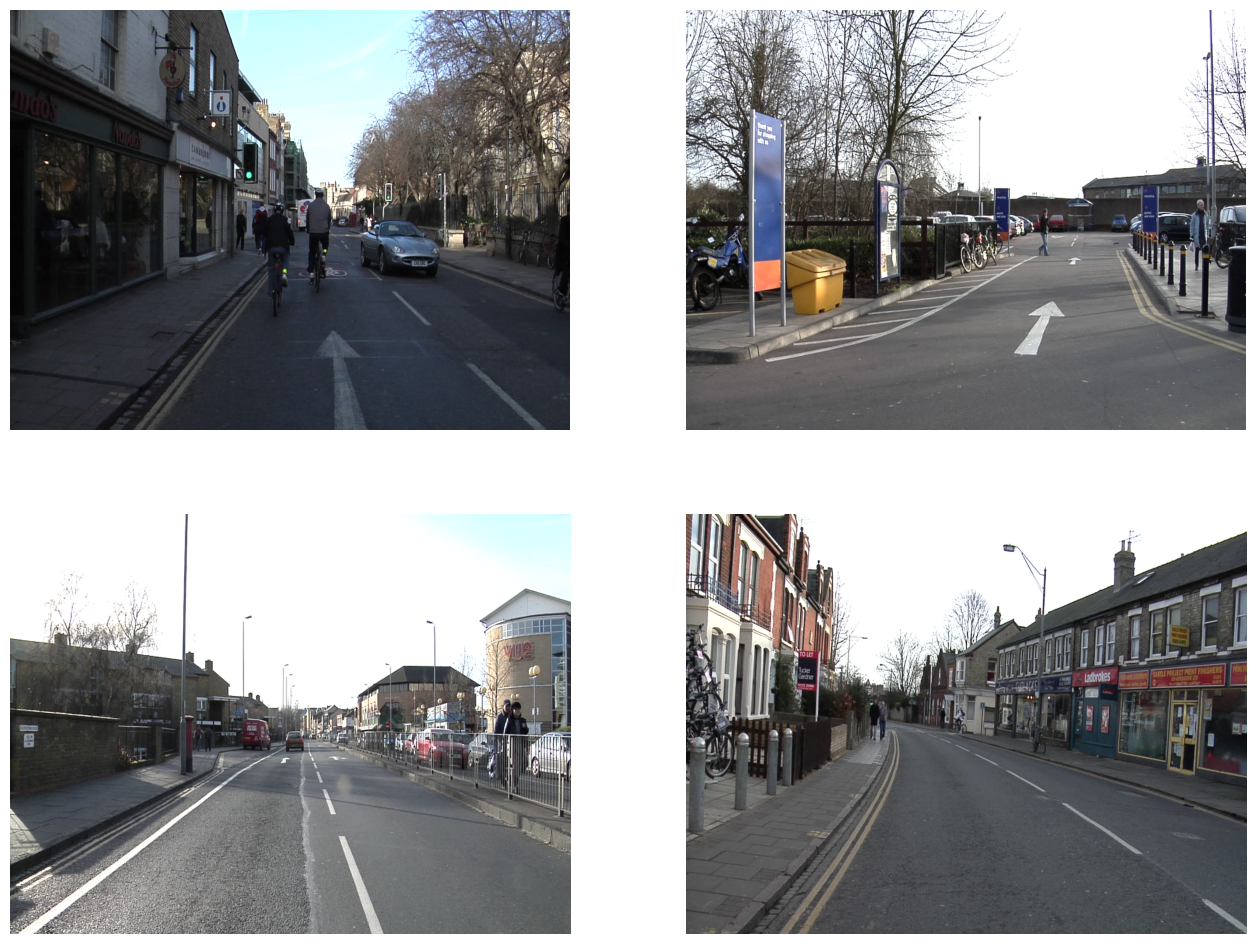

In [16]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

for idx, axis in enumerate(ax.flat):
    image = load_image(image_paths[idx])
    images.append(image)
    axis.imshow(image[0])
    axis.axis('off')

### Define a dictionary that maps class IDs to class names and class colors

In [17]:
class_index = \
    {
         0: [(64, 128, 64),  'Animal'],
         1: [(192, 0, 128),  'Archway'],
         2: [(0, 128, 192),  'Bicyclist'],
         3: [(0, 128, 64),   'Bridge'],
         4: [(128, 0, 0),    'Building'],
         5: [(64, 0, 128),   'Car'],
         6: [(64, 0, 192),   'Cart/Luggage/Pram'],
         7: [(192, 128, 64), 'Child'],
         8: [(192, 192, 128),'Column Pole'],
         9: [(64, 64, 128),  'Fence'],
        10: [(128, 0, 192),  'LaneMkgs Driv'],
        11: [(192, 0, 64),   'LaneMkgs NonDriv'],
        12: [(128, 128, 64), 'Misc Text'],
        13: [(192, 0, 192),  'Motorcycle/Scooter'],
        14: [(128, 64, 64),  'Other Moving'],
        15: [(64, 192, 128), 'Parking Block'],
        16: [(64, 64, 0),    'Pedestrian'],
        17: [(128, 64, 128), 'Road'],
        18: [(128, 128, 192),'Road Shoulder'],
        19: [(0, 0, 192),    'Sidewalk'],
        20: [(192, 128, 128),'Sign Symbol'],
        21: [(128, 128, 128),'Sky'],
        22: [(64, 128, 192), 'SUV/Pickup/Truck'],
        23: [(0, 0, 64),     'Traffic Cone'],
        24: [(0, 64, 64),    'Traffic Light'],
        25: [(192, 64, 128), 'Train'],
        26: [(128, 128, 0),  'Tree'],
        27: [(192, 128, 192),'Truck/Bus'],
        28: [(64, 0, 64),    'Tunnel'],
        29: [(192, 192, 0),  'Vegetation Misc'],
        30: [(0, 0, 0),      'Void'],
        31: [(64, 192, 0),   'Wall']  
    }

## 2 Model Inference using TensorFlow Hub

### Load the model

In [18]:
model_url = "https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1"
print("loading model:", model_url)

seg_model = hub.load(model_url)
print("\nmodel loaded!")

loading model: https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1

model loaded!


### Perform inference

#### call model predict() function

In [19]:
# Make a predcition using the first image in the list of images
pred_mask = seg_model.predict(images[0])

# The predicted mask has teh following shape: [B, H, W, C]
print("Shape of predicted mask: ", pred_mask.shape)

Shape of predicted mask:  (1, 720, 960, 33)


#### post-process predicted segmentation mask
Remove batch dimension and background class


In [20]:
# Covert tensor to np array
pred_mask = pred_mask.numpy()

# The 1st label is the background class added by the model, but we can remove it for this dataset
pred_mask = pred_mask[:,:,:,1:]

# Remove batch dimension
pred_mask = np.squeeze(pred_mask)

#Print the shape to confirm: [H, W, C]
print('Shape of predicted mask agter removal of batch dimension and background class: ', pred_mask.shape)

Shape of predicted mask agter removal of batch dimension and background class:  (720, 960, 32)


Visualize intermediate results

(-0.5, 959.5, 719.5, -0.5)

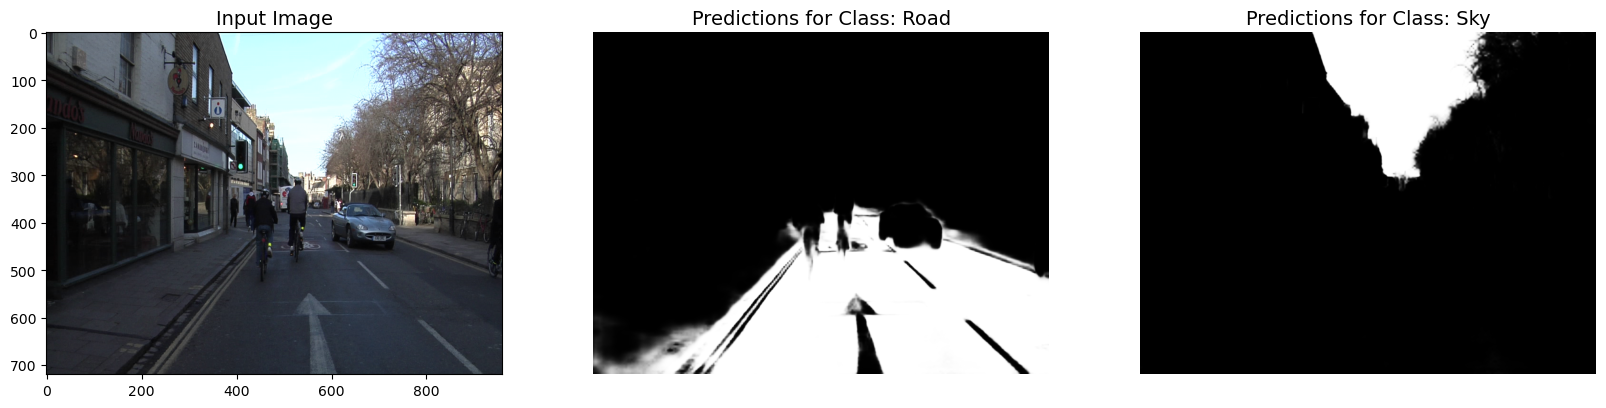

In [21]:
# Each channel in pred_mask contains the probabilities that the pixels
# in the original image are associated with the class for that channel

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1,3,2)
plt.title('Predictions for Class: Road', fontsize=14)
plt.imshow(pred_mask[:,:,17], cmap='gray') # Class 17 corresponds to 'road' class
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Predictions for Class: Sky', fontsize=14)
plt.imshow(pred_mask[:,:,21], cmap='gray') # Class 21 corresponds to 'sky' class
plt.axis('off')

Assign each pixel a class label

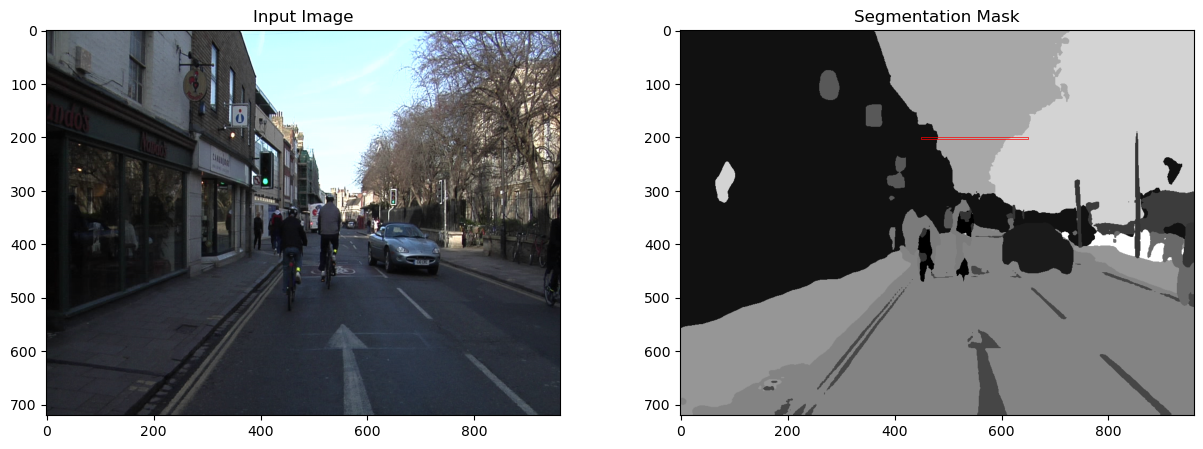

In [25]:
# Assign each pixel in the image a class ID based on the channel that contains the
# highest probability score. THis can be implemented using the 'argmax' function
pred_mask_class = np.argmax(pred_mask, axis=-1)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Input Image", fontsize=12)
plt.imshow(np.squeeze(images[0]))

plt.subplot(1,2,2)
plt.title("Segmentation Mask", fontsize=12)
plt.imshow(pred_mask_class, cmap='gray') # isolates each of the 32 classes
plt.gca().add_patch(Rectangle((450,200),200,3, edgecolor='red', facecolor='none', lw=.5));

In [26]:
print(pred_mask_class[200,450:650])

[ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 26 26 21 21 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26]


Convert gray scale mask (single channel mask) to a color representation

In [29]:
# Function to convert
def class_to_rgb(mask_class, class_index):

    # Create RGB channels
    r_map = np.zeros_like(mask_class).astype(np.uint8)
    g_map = np.zeros_like(mask_class).astype(np.uint8)
    b_map = np.zeros_like(mask_class).astype(np.uint8)

# Populate RG color channels based on teh color assigned to each class
    for class_id in range(len(class_index)):
        index = mask_class == class_id
        r_map[index] = class_index[class_id][0][0]
        g_map[index] = class_index[class_id][0][1]
        b_map[index] = class_index[class_id][0][2]

    seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)

    return seg_map_rgb

(-0.5, 959.5, 719.5, -0.5)

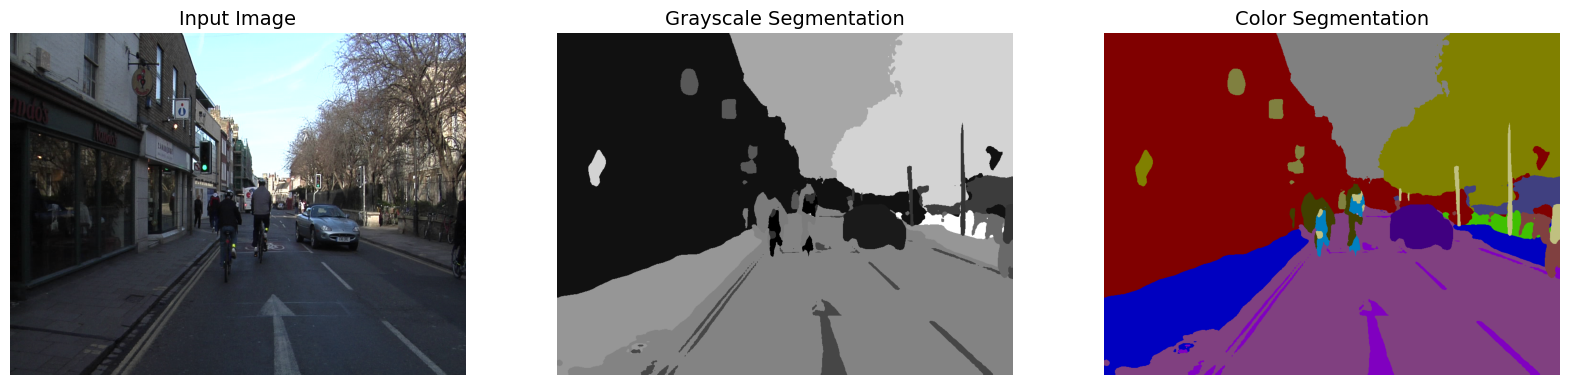

In [30]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title('Input Image', fontsize=14)
plt.imshow(np.squeeze(images[0]))
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Grayscale Segmentation', fontsize=14)
plt.imshow(pred_mask_class, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Color Segmentation", fontsize=14)
plt.imshow(pred_mask_rgb, cmap="gray")
plt.axis("off")



## 3 Formalize the Implementation

### Image overlay
Overlays color segmentation map onto original image with transparency factors

In [31]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, seg_map_rgb):
    
    alpha = 1.0  # Transparency for the original image.
    beta  = 0.6  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    image = (image * 255.0).astype(np.uint8)
    seg_map_rgb = cv2.cvtColor(seg_map_rgb, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, seg_map_rgb, beta, gamma)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

### Run Inference
Runs all the logic to make predictions from the model and post-process

In [33]:
def run_inference(images, model):

    for img in images:

        # Forward pass through the model (convert tensor output to numpy array)
        pred_mask = model.predict(img).numpy()

        # Remove the background class added by the model
        pred_mask = pred_mask[:,:,:,1:]

        # Remove batch dimension
        pred_mask = np.squeeze(pred_mask)

        # `pred_mask` is a numpy array of shape [H, W, 32] where each channel contain the probability
        # scores associated with a given class
        pred_mask_class = np.argmax(pred_mask, axis=-1)

        # Convert the predicted (class) segmentation map to color
        pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

        fig = plt.figure(figsize=(20,15))

        # Display original image
        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(img[0])
        ax1.title.set_text("Input Image")
        plt.axis("off")

        # Display predicted color segmentation mask
        ax2 = fig.add_subplot(1,3,2)
        ax2.title.set_text("Predicted Mask")
        ax2.imshow(pred_mask_rgb)
        plt.axis("off")

        # Display predicted color segmentation mask overlayed on original image
        overlayed_image = image_overlay(img[0], pred_mask_rgb)
        ax3 = fig.add_subplot(1,3,3)
        ax3.title.set_text("Overlayed Image")
        ax3.imshow(overlayed_image)
        plt.axis("off")

#### Color legend

In [34]:
def plot_color_legend(class_index):
    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=16, figsize=(20, 3))
    plt.subplots_adjust(wspace=0.5, hspace=0.01)

    # Display color legend.
    for i, axis in enumerate(ax.flat):
        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize=8)
        axis.axis("off")

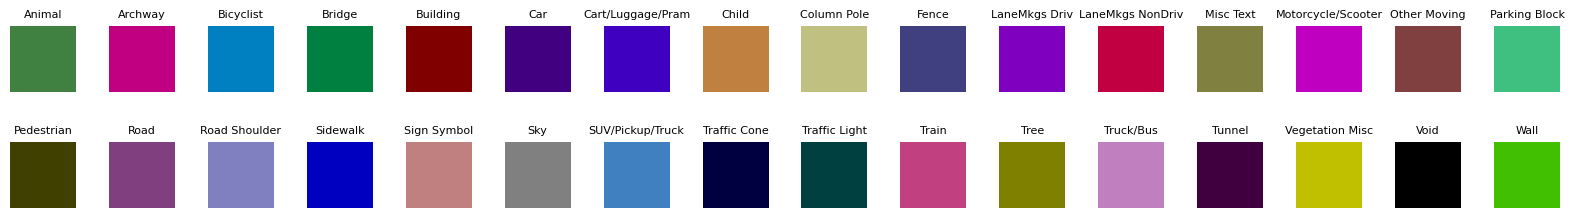

In [35]:
plot_color_legend(class_index)

### Make predictions on sample images

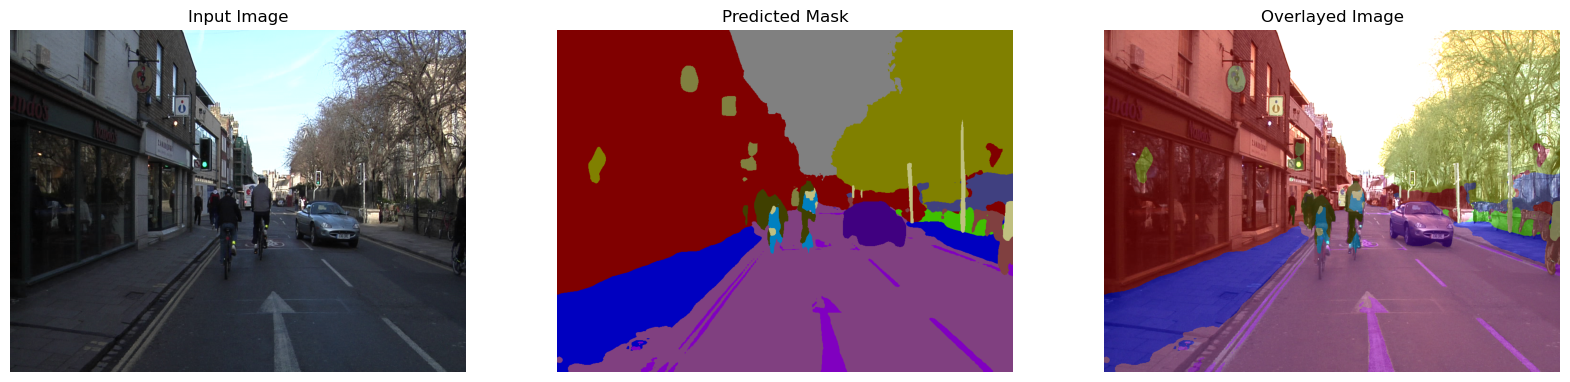

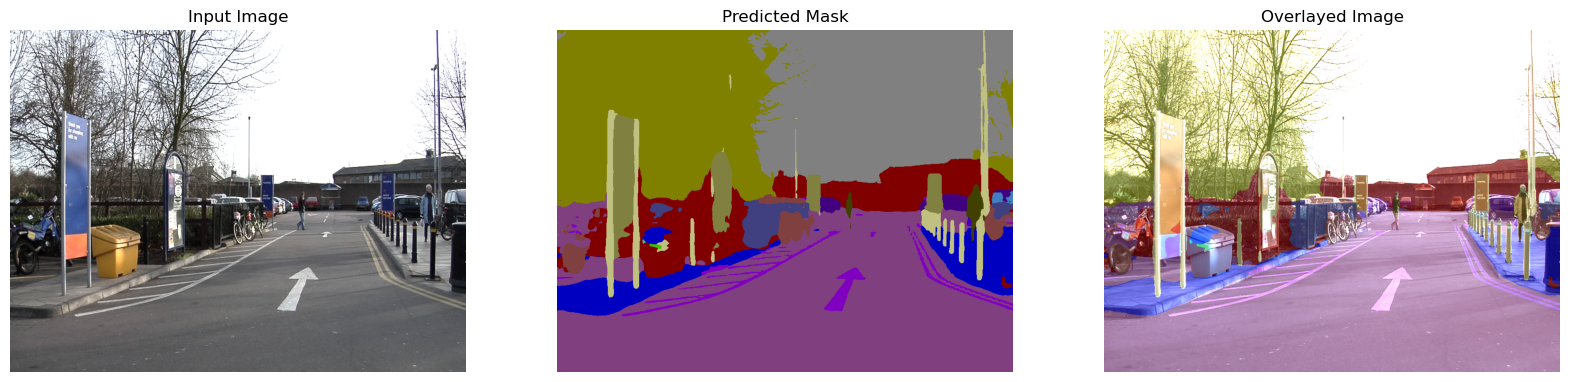

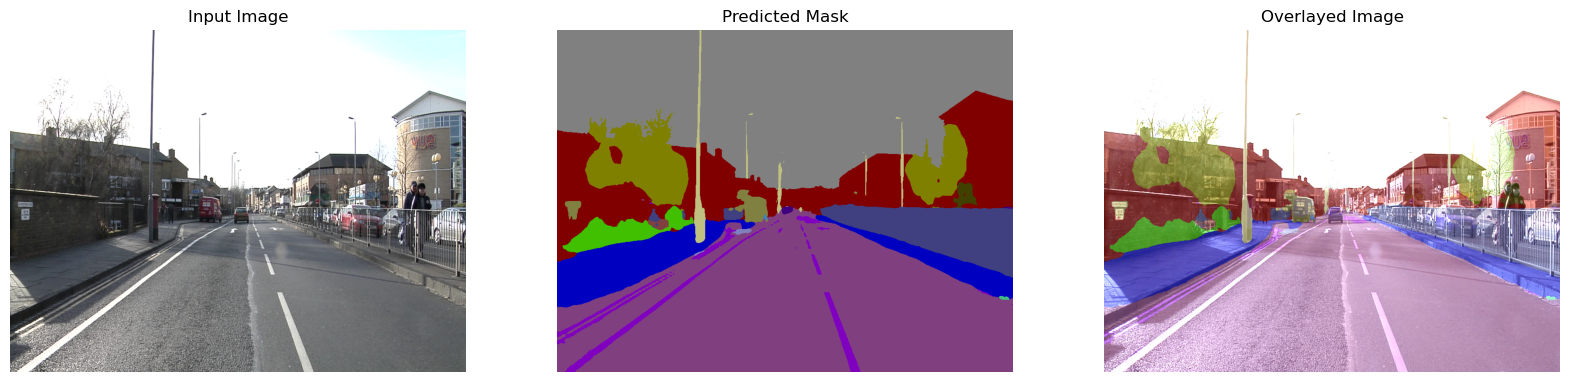

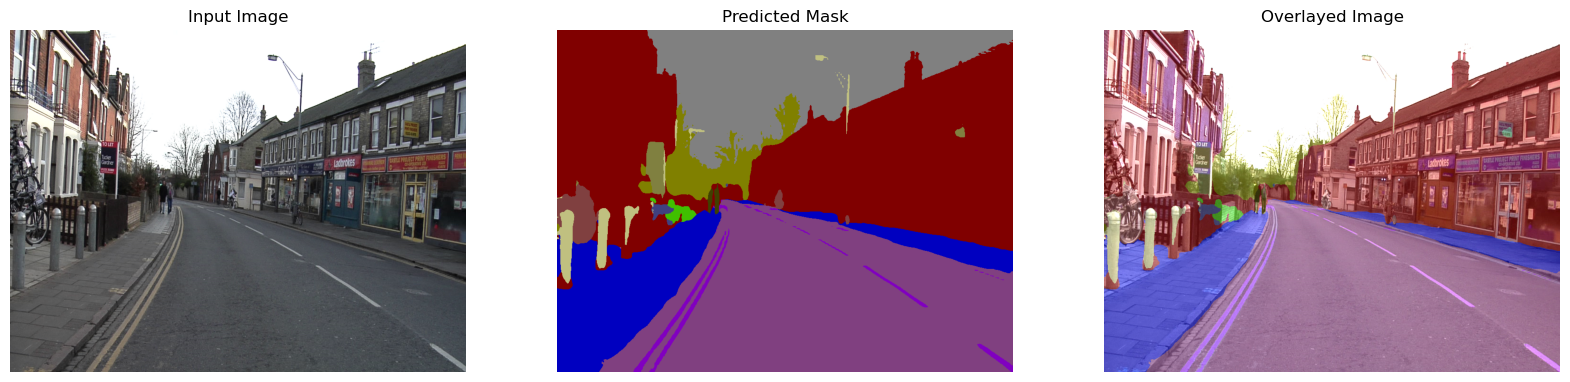

In [36]:
run_inference(images, seg_model)